Initial shape: (18029, 39)
['Database Developer' 'Portal Administrator'
 'Systems Security Administrator' 'Business Systems Analyst'
 'Software Systems Engineer' 'Business Intelligence Analyst'
 'CRM Technical Developer' 'Mobile Applications Developer' 'UX Designer'
 'Quality Assurance Associate' 'Web Developer'
 'Information Security Analyst' 'CRM Business Analyst' 'Technical Support'
 'Project Manager' 'Information Technology Manager' 'Programmer Analyst'
 'Design & UX' 'Solutions Architect' 'Systems Analyst'
 'Network Security Administrator' 'Data Architect' 'Software Developer'
 'E-Commerce Analyst' 'Technical Services/Help Desk/Tech Support'
 'Information Technology Auditor' 'Database Manager'
 'Applications Developer' 'Database Administrator' 'Network Engineer'
 'Software Engineer' 'Technical Engineer' 'Network Security Engineer'
 'Software Quality Assurance (QA) / Testing']

Columns in dataset:
['Acedamic percentage in Operating Systems', 'percentage in Algorithms', 'Percentage 

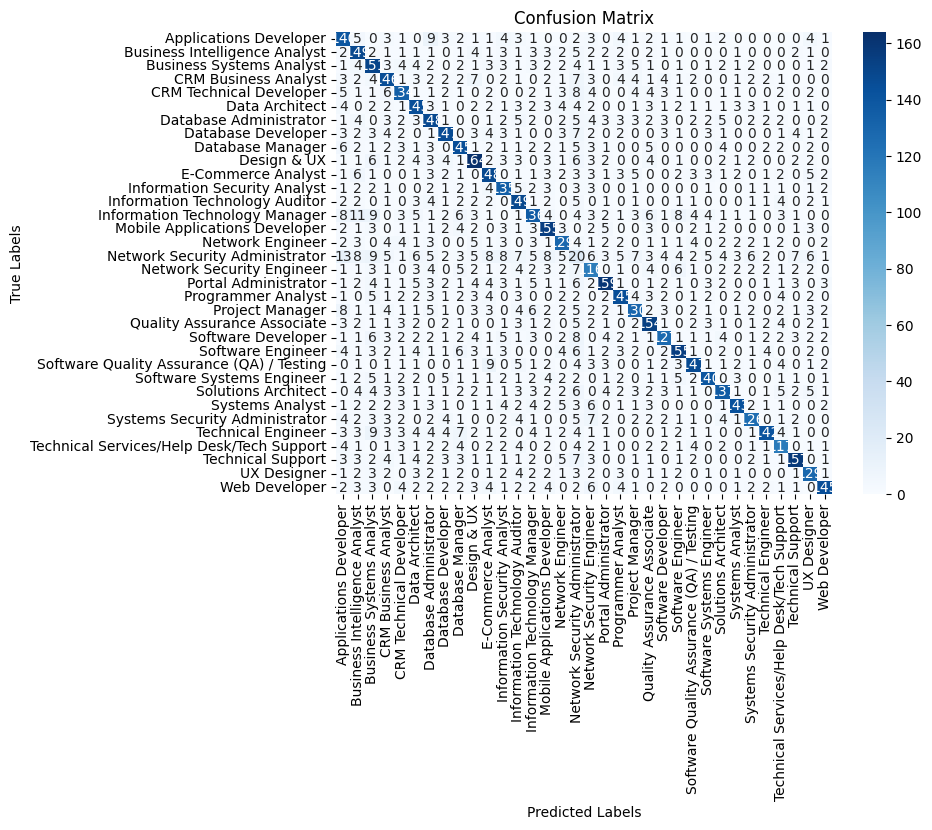

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("dataset.csv")  # Replace with your file name
print("Initial shape:", df.shape)

unique_values = df['Suggested Job Role'].unique()
print(unique_values)


# Print columns to identify the target column
print("\nColumns in dataset:")
print(df.columns.tolist())

# Define columns to exclude
columns_to_exclude = [
    "Logical quotient rating", "talenttests taken?", "olympiads",
    "Taken inputs from seniors or elders", "interested in games",
    "Interested Type of Books", "Salary Range Expected", "In a Realtionship?",
    "Salary/work", "Gentle or Tuff behaviour?",
]

# Exclude the specified columns from the dataset
df = df.drop(columns=columns_to_exclude, errors='ignore')
print(f"\nShape after excluding specified columns: {df.shape}")

# Adding new feature columns
df['Knowledge Engineering'] = (df['percentage in Algorithms'] + df['Percentage in Mathematics']) / 2
df['System Engineering'] = (df['Acedamic percentage in Operating Systems'] +
                             df['Percentage in Computer Architecture'] +
                             df['Percentage in Electronics Subjects']) / 3
df['Networks and Security'] = (df['Percentage in Computer Networks'] +
                               df['Percentage in Communication skills']) / 2
df['Software Development'] = (df['Percentage in Programming Concepts'] +
                               df['Percentage in Software Engineering']) / 2
df['Professional Development'] = (df['Percentage in Communication skills'] +
                                   df['Percentage in Mathematics']) / 2

df = df.drop(columns=[
    'percentage in Algorithms', 'Percentage in Mathematics', 
    'Acedamic percentage in Operating Systems', 'Percentage in Computer Architecture',
    'Percentage in Electronics Subjects', 'Percentage in Computer Networks',
    'Percentage in Programming Concepts', 'Percentage in Software Engineering',
    'Percentage in Communication skills'
], errors='ignore')
# Manually set the correct target column name here:
TARGET_COL = "Suggested Job Role"  # Change this if it's named differently

# Check if target column exists
if TARGET_COL not in df.columns:
    raise ValueError(f"Column '{TARGET_COL}' not found in dataset. Please check the column names.")

# Encode the target labels
le = LabelEncoder()
df[TARGET_COL] = le.fit_transform(df[TARGET_COL])

# Separate features and target
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

# One-hot encode categorical features
X = pd.get_dummies(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data to DataFrame and display columns
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nScaled Features :")
print(X_scaled_df.head())

# Balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

joblib.dump(model, 'model.pkl')         # Trained RandomForest
joblib.dump(scaler, 'scaler.pkl')       # Scaler used on training data
joblib.dump(X.columns.tolist(), 'columns.pkl')  # Final column order after one-hot encoding
joblib.dump(le, 'le.pkl')

# Accuracy
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

# Calculate Total Accuracy
# Combine train and test predictions with actual labels
combined_preds = np.concatenate([train_preds, test_preds])
combined_actual = np.concatenate([y_train, y_test])
total_acc = accuracy_score(combined_actual, combined_preds)

print("Total combined predictions:", len(combined_preds))
print("Total combined actual labels:", len(combined_actual))

correct_preds = np.sum(combined_preds == combined_actual)
print("Number of correct predictions:", correct_preds)
print("Total samples:", len(combined_actual))

# Classification Report
print("\n📊 Classification Report (Test Data):")
print(classification_report(y_test, test_preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)

# Print all accuracy details
print(f"\n✅ Training Accuracy: {train_acc:.2f}")
print(f"✅ Testing Accuracy: {test_acc:.2f}")
print(f"✅ Total Accuracy: {total_acc:.2f}")  # Displaying total accuracy

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()